<a href="https://colab.research.google.com/github/mehdi-mustapha/Hello-World/blob/main/01_NLP_with_Tensorflow_traduit_et_execute_sur_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Natural Language Processing 

In this tutorial, we are going to do some text classification. These texts are translations of the Illiad. We are going to teach our NLP algorithm to understand each of the translations and to assign them to the right translator. Our learning process will be the same as for CNN : 

1. Data Preprocessing 
2. Modeling 
3. Evaluation 

# Introduction au traitement du langage naturel 

###Dans ce tutoriel, nous allons faire de la classification de textes. Ces textes sont des traductions de l'Illiade. Nous allons apprendre à notre algorithme NLP à comprendre chacune des traductions et à les assigner au bon traducteur. Notre processus d'apprentissage sera le même que pour CNN : 

### 1. Prétraitement des données 
### 2. Modélisation 
### 3. Évaluation 



## Data Preprocessing

### Import Data 

In [ ]:
# TensorFlow installation
!pip install tensorflow

In [ ]:
# Import librairies TensorFlow & Pathlib 
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib 
import pandas as pd
tf.__version__

'2.7.0'

In [ ]:
# Import text files containing the translations of the Illiad
# Importer les fichiers texte contenant les traductions de l'Illiade

DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  tf.keras.utils.get_file(name, 
                          DIRECTORY_URL+name,
                          cache_subdir="/content")

819200/807992 [==============================] - 0s 0us/step


In [ ]:
# Let's take a look at the folders in /content from colab
# Regardons les dossiers dans /content de colab.

all_files = pathlib.Path("/content")
list(all_files.glob("*"))

[PosixPath('/content/.config'),
 PosixPath('/content/derby.txt'),
 PosixPath('/content/butler.txt'),
 PosixPath('/content/cowper.txt'),
 PosixPath('/content/sample_data')]

In [ ]:
# Let's take only files with the .txt extension
# Prenons seulement les fichiers avec l'extension .txt

text_files = [path for path in list(all_files.glob("*")) if path.suffix==".txt"]
text_files

[PosixPath('/content/derby.txt'),
 PosixPath('/content/butler.txt'),
 PosixPath('/content/cowper.txt')]

In [ ]:
for path in text_files:
  print(path.name)

derby.txt
butler.txt
cowper.txt


In [ ]:
with open(text_files[0]) as text:
  text_lines = text.readlines()

In [ ]:
texts = []
labels = []

for i, path in enumerate(text_files):
  with open(path) as text:
    text_lines = text.readlines()
    texts += text_lines
    labels += [i for line in text_lines]

print(len(texts))
print(len(labels))

df = pd.DataFrame({"text":texts, "label":labels})
df.head()

49608
49608


,text,label
0,"﻿Of Peleus' son, Achilles, sing, O Muse,\n",0
1,"The vengeance, deep and deadly; whence to Gree...",0
2,Unnumbered ills arose; which many a soul\n,0
3,Of mighty warriors to the viewless shades\n,0
4,Untimely sent; they on the battle plain\n,0


### Tokenize

Nous allons maintenant passer par une phase de Tokenisation. Autrement dit, nous allons assigner un numéro à chacun des mots présent dans notre corpus de texte. 

In [ ]:
import spacy
spacy.__version__

'2.2.4'

In [ ]:
nlp = spacy.load("en")

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:
def lemmatize_text(text):
  text = ''.join(ch for ch in text if ch.isalnum() or ch==" ")
  text = text.replace(" +"," ").lower().strip()
  text=nlp(text)
  lemma = ' '.join([token.lemma_ for token in text if token.text not in STOP_WORDS])
  return lemma

df["text_clean"] = df["text"].apply(lambda x: lemmatize_text(x))
df.head()

,text,label,text_clean
0,"﻿Of Peleus' son, Achilles, sing, O Muse,\n",0,peleus son achille sing o muse
1,"The vengeance, deep and deadly; whence to Gree...",0,vengeance deep deadly greece
2,Unnumbered ills arose; which many a soul\n,0,unnumbered ill arise soul
3,Of mighty warriors to the viewless shades\n,0,mighty warrior viewless shade
4,Untimely sent; they on the battle plain\n,0,untimely send battle plain


In [ ]:
# Create a tokenizer instance
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df["text_clean"])

# Tokenization + Encoding
df["encoded"] = tokenizer.texts_to_sequences(df["text_clean"])
df.head()

,text,label,text_clean,encoded
0,"﻿Of Peleus' son, Achilles, sing, O Muse,\n",0,peleus son achille sing o muse,"[92, 1, 9, 2110, 251, 1173]"
1,"The vengeance, deep and deadly; whence to Gree...",0,vengeance deep deadly greece,"[1053, 147, 818, 130]"
2,Unnumbered ills arose; which many a soul\n,0,unnumbered ill arise soul,"[8204, 365, 303, 187]"
3,Of mighty warriors to the viewless shades\n,0,mighty warrior viewless shade,"[86, 88, 3293, 487]"
4,Untimely sent; they on the battle plain\n,0,untimely send battle plain,"[3593, 67, 25, 101]"


In [ ]:
# pad sequences
# séquences de compactage

padded_ecoded_text = tf.keras.preprocessing.sequence.pad_sequences(df["encoded"], padding="post")
padded_ecoded_text

array([[  92,    1,    9, ...,    0,    0,    0],
       [1053,  147,  818, ...,    0,    0,    0],
       [8204,  365,  303, ...,    0,    0,    0],
       ...,
       [1181, 1087,  423, ...,    0,    0,    0],
       [2005,  161,   79, ...,    0,    0,    0],
       [2758,  436,    4, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# create the tensorflow dataset
all_encoded_data = tf.data.Dataset.from_tensor_slices((padded_ecoded_text, df["label"].values))

# shuffle dataset
# Brasser les données

all_encoded_data = all_encoded_data.shuffle(len(padded_ecoded_text))

In [ ]:
# Train Test Split
# Train Test Division

TAKE_SIZE = 5000

train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(50000)
train_data = train_data.batch(64)

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
# Let's look at a batch
# Regardons un lot

for sample_text, sample_labels in test_data.take(1):
  print(sample_text, sample_labels)

tf.Tensor(
[[1428  131  100 1104    0    0    0    0    0    0]
 [  85   70   17  506  121    0    0    0    0    0]
 [4988 4654  154    0    0    0    0    0    0    0]
 [   7  149   64  559 1901  107 1164    0    0    0]
 [1896  196  978  190    0    0    0    0    0    0]
 [1196   17  164   96  877   54    0    0    0    0]
 [  47  675 2801    0    0    0    0    0    0    0]
 [ 477  157    0    0    0    0    0    0    0    0]
 [ 166  226  313    0    0    0    0    0    0    0]
 [ 128   39 8272    0    0    0    0    0    0    0]
 [ 512 7928 1005    0    0    0    0    0    0    0]
 [1033 3794  563    0    0    0    0    0    0    0]
 [ 976  463  227  485    0    0    0    0    0    0]
 [2424  274   85  907    0    0    0    0    0    0]
 [ 670   39    0    0    0    0    0    0    0    0]
 [   9 2646   15 6040   57    0    0    0    0    0]
 [ 851   66  141    0    0    0    0    0    0    0]
 [ 104 2432    0    0    0    0    0    0    0    0]
 [ 104 1744 1257   22    0    0    

## Modeling

Let's create a model based on an LSTM layer to classify our different translations 

## Modélisation

### Créons un modèle basé sur une couche LSTM pour classer nos différentes traductions. 

In [ ]:
vocab_size = len(tokenizer.word_index)
vocab_size

13677

In [ ]:
model = tf.keras.Sequential([
                  # Layer Input Word Embedding  
                  # Couche d'entrée d'incorporation de mots  

                  tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[10,]),

                  # Flatten
                  # Aplatir

                  tf.keras.layers.Flatten(),
                  
                  # Layer Dense classique 
                  # Couche dense classique 

                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),

                  # Output layer with number of output neurons equal to class number with softmax function
                  # Couche de sortie avec un nombre de neurones de sortie égal au nombre de classes avec la fonction softmax.
                  
                  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 64)            875392    
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 64)                41024     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 918,595
Trainable params: 918,595
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Using a simple compiler with an Adam optimizer to calculate our gradients 
# Utiliser un simple compilateur avec un optimiseur Adam pour calculer nos gradients

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Model training
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
697/697 [==============================] - 6s 5ms/step - loss: 0.7058 - sparse_categorical_accuracy: 0.6662 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8178
Epoch 2/10
697/697 [==============================] - 4s 5ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.3138 - val_sparse_categorical_accuracy: 0.8830
Epoch 3/10
697/697 [==============================] - 4s 5ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.2394 - val_sparse_categorical_accuracy: 0.9078
Epoch 4/10
697/697 [==============================] - 4s 5ms/step - loss: 0.2768 - sparse_categorical_accuracy: 0.8887 - val_loss: 0.1972 - val_sparse_categorical_accuracy: 0.9280
Epoch 5/10
697/697 [==============================] - 4s 5ms/step - loss: 0.2379 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.1670 - val_sparse_categorical_accuracy: 0.9404
Epoch 6/10
697/697 [==============================] - 4s 5ms/step - loss: 0.2096 - sparse_categorica

## Evaluation 

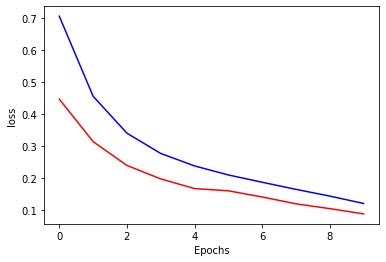

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
# Visualisation du processus de formation sur la fonction de perte 

plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Visualisation de l'entrainement sur l'accuracy 

plt.plot(history.history["accuracy"], color="b")  
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

KeyError: ignored